In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from prediction_pipeline.preprocessing import *
import datetime
from multiprocessing import Pool

/home/hv270/platelets/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

In [3]:
FACS_COLS = ["FSC","SSC","SFL"]

In [4]:
df = pd.read_hdf("%s/processed/PLT_unadjusted.hdf" % data_dir,key="PLT")

In [5]:
#ID_mapping = {}
#for i, ID in enumerate(df.ID.unique().tolist()):
#    ID_mapping[ID] = i
#df["ID"] = df["ID"].replace(ID_mapping)
#df["ID"] = df["ID"].astype(int)

In [6]:
df[FACS_COLS] -= df[FACS_COLS].mean(axis=0)
df[FACS_COLS] /= df[FACS_COLS].std(axis=0)

In [7]:
df.sample(5)

,ID,FSC,SSC,SFL
94567678,INT_116_5125500,-0.577293,0.548827,-0.442521
126979444,INT_116_6629500,-0.577293,-0.798452,-0.654402
106175416,INT_116_5377800,-1.223861,-0.388411,-1.374801
55805064,INT_116_313500,1.324378,-0.915607,0.235502
166049548,INT_116_949500,-0.349092,1.427488,-0.188262


In [8]:
s = df.sample(1000)
s2 = df.sample(1000)

In [9]:
T = np.array([[-2,-2,-2],
              [-1,-1.25,-1.25],
              [-1.25,-0.75,-1.25],
              [0,-.75,-.5],
              [-0.5,0.2,0],[.5,.5,0.5],[2,2,1.5],[3,3,2]])

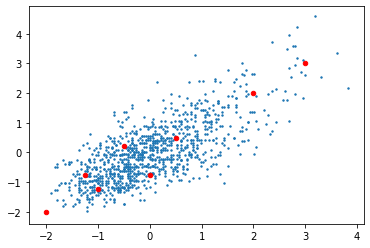

In [10]:
plt.scatter(s.FSC,s.SSC,s=2)
plt.scatter(T[:,0],T[:,1],c="red",s=20)

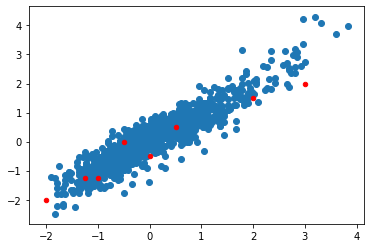

In [11]:
plt.scatter(s.FSC,s.SFL)
plt.scatter(T[:,0],T[:,2],c="red",s=20)

In [12]:
def k(X,x,sigma):
    D = np.linalg.norm(X-x,axis=-1)
    return np.exp(-(D/(2*sigma))**2)

In [13]:
def MMD_stat(X,Y,sigma,T):
    Z = (k(X,np.expand_dims(T,axis=1),sigma) - k(Y,np.expand_dims(T,axis=1),sigma)).T
    W = np.mean(Z,axis=0)
    n = Z.shape[0]
    sigma = (1./n)*(Z.T@Z)
    try:
        S = n * W @ np.linalg.inv(sigma) @ W
    except np.linalg.LinAlgError:
        S = 0.
    return S

In [14]:
def MMD_linear(X,Y,sigma):
    N = X.shape[0]
    M = N // 2
    L = X.shape[1]
    X_ = np.concatenate([X[:M],Y[:M]],1)
    Y_ = np.concatenate([X[M:],Y[M:]],1)
    return np.mean(k(X_[:,:L],X_[:,L:],sigma) - \
                  (k(X_[:,:L],Y_[:,:L],sigma) + k(Y_[:,:L],X_[:,:L],sigma)) + \
                   k(Y_[:,:L],Y_[:,L:],sigma))

In [15]:
from scipy.spatial import distance_matrix

In [16]:
def MMD(X,Y,sigma):
    D = distance_matrix(X,Y)
    return np.mean(np.exp(-D**2/sigma))

In [17]:
all_IDs = df.ID.unique().tolist()
int_IDs = [ID for ID in all_IDs if "INT" in ID]
pfc_IDs = [ID for ID in all_IDs if ID not in int_IDs]

In [34]:
IDs = list(np.random.choice(pfc_IDs,100)) + list(np.random.choice(int_IDs,100))  #+ list(np.random.choice(int_IDs,2000,replace=False))

In [35]:
Xs = {} 
for ID, df_ in tqdm(df.loc[df.ID.isin(IDs)].groupby("ID")):
    Xs[ID] = df_[FACS_COLS].sample(3000).values

100%|██████████| 192/192 [00:00<00:00, 909.28it/s]


In [20]:
sigma = 1.

# Option 1 : Nearest neighbors

In [21]:
def get_distance_from_flat_vectors(X,Y):
    X_, Y_ = np.reshape(X,(-1,3)), np.reshape(Y,(-1,3))
    return MMD(X_,Y_,sigma,T)

In [22]:
from sklearn.neighbors import NearestNeighbors

In [19]:
flat_Xs = np.stack([np.reshape(Xs[ID],(-1,)) for ID in IDs],axis=0)
flat_Xs.shape

(33367, 3000)

In [ ]:
K = 50
nn = NearestNeighbors(n_neighbors=K,metric=get_distance_from_flat_vectors,n_jobs=12,)
nn.fit(flat_Xs)
D, ind = nn.kneighbors(return_distance=True)

# Option 2 : distance matrix

In [23]:
def get_distance(arg):
    i,j = arg
    X = Xs[IDs[i]]
    Y = Xs[IDs[j]]
    return i,j,MMD_stat(X,Y,sigma,T)

In [24]:
args = []
for i, ID1 in tqdm(enumerate(Xs),total=len(Xs)):
    for j, ID2 in enumerate(Xs):
        if j <= i: continue
        #if D[i,j] > 0: continue
        args.append((i,j))

100%|██████████| 163/163 [00:00<00:00, 20915.70it/s]


In [25]:
D = np.zeros((len(IDs),len(IDs)))

In [26]:
p = Pool(12)
for i, j, d in tqdm(p.imap_unordered(get_distance,args),total=len(args)):
    D[i,j] = d
p.join()
p.close()

100%|██████████| 13203/13203 [01:05<00:00, 202.38it/s]


ValueError: Pool is still running

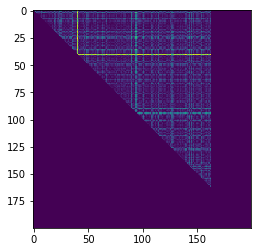

In [27]:
plt.imshow(D)

In [28]:
D = D + D.T

In [29]:
from sklearn.manifold import MDS

In [30]:
U = MDS(dissimilarity='precomputed').fit_transform(D)

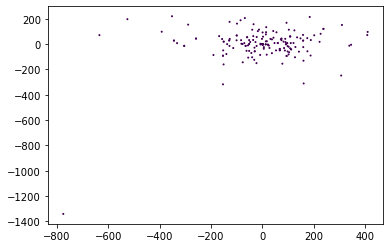

In [31]:
plt.scatter(U[:,0],U[:,1],s=1,c=["INT" in ID for ID in IDs])

In [32]:
np.mean(["INT" in ID for ID in IDs])

0.0

In [33]:
U_df = pd.DataFrame(index=IDs)
U_df[0] = U[:,0]
U_df[1] = U[:,1]
info = pd.read_csv("%s/processed/adj_sysmex_features_age_sex.csv" % data_dir,index_col=0)
U_df = pd.merge(U_df,info,left_index=True,right_index=True,how="inner")
pheno = pd.read_csv("%s/processed/phenotypes.csv" % data_dir,index_col=0)
U_df = pd.merge(U_df,pheno[["SAMPLE_ID","ADP"]],left_index=True,right_on="SAMPLE_ID",how="left")

In [216]:
pheno

,PROJECT,SAMPLE_ID,DATE,REST_FIB_1,REST_FIB_2,REST_PSEL_1,REST_PSEL_2,ADP_FIB_1,ADP_FIB_2,CRP_FIB_1,...,PAR4_FIB_VAL_OK,PAR4_FIB_QC_OK,PAR4_PSEL_REP_DELTA,PAR4_PSEL_REP_OK,PAR4_PSEL,PAR4_PSEL_VAL_OK,PAR4_PSEL_QC_OK,PAR4,DAYS,cohort
0,PFC_4_U,C0WX14,2016-01-12,1.979151,2.007390,-0.452823,-0.392173,1.036594,1.058580,2.052054,...,True,1,-0.144908,True,-0.685623,True,1,0.207053,-554,0.0
1,PFC_4_U,C0WX4Z,2016-01-12,-0.735112,-2.031737,0.063618,-0.137273,0.272949,0.582431,0.547542,...,True,1,0.069331,True,-0.166033,True,1,-0.042351,-554,0.0
2,PFC_4_U,C0WX6V,2016-01-12,0.105676,-0.160845,-0.268550,-0.304724,-0.257389,-0.185082,0.064717,...,True,1,0.085186,True,-2.451255,True,1,-1.942698,-554,0.0
3,PFC_4_U,C0WX7T,2016-01-12,-0.010914,0.576895,0.270801,0.405902,0.991922,0.957245,1.627910,...,True,1,0.139216,True,-0.158951,True,1,0.128823,-554,0.0
4,PFC_4_U,C0WX8R,2016-01-12,-1.117794,-0.951069,-0.234577,-0.249044,0.131977,-0.016889,0.244401,...,True,1,-0.106476,True,0.165842,True,1,0.101175,-554,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,PFC_4,C1A2PI,2018-11-28,-0.499027,-0.029118,-0.137659,-0.100298,-0.012903,-0.054591,-1.255076,...,True,1,0.092551,True,-1.231650,True,1,-0.781000,497,1.0
533,PFC_4,C1A2RE,2018-11-29,0.508091,0.748296,-0.166792,-0.215388,0.454233,0.438132,0.905671,...,True,1,0.149773,True,-0.416502,True,1,-0.022963,498,1.0
534,PFC_4,C1A2TA,2018-11-29,-0.123331,-0.724070,-0.576097,-0.664206,0.015207,-0.229225,-3.277229,...,True,1,0.066929,True,-1.283859,True,1,-0.728420,498,1.0
535,PFC_4,C1A2X2,2018-11-30,0.524721,-0.001618,-0.770366,-0.929216,0.908069,0.839064,0.488176,...,True,1,0.021661,True,-0.812626,True,1,0.177470,499,1.0


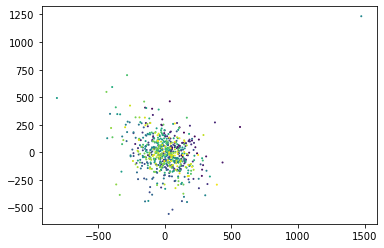

In [217]:
plt.scatter(U_df[0],U_df[1],c=U_df["rank"],s=1)

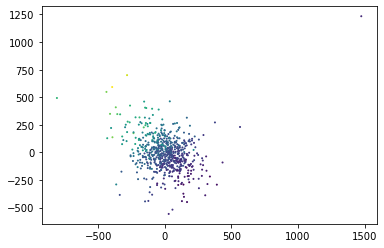

In [218]:
plt.scatter(U_df[0],U_df[1],c=U_df["PDW"],s=1)

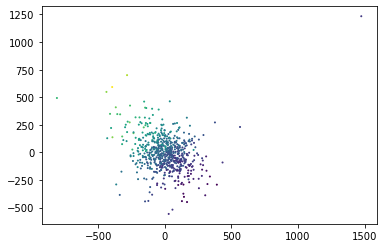

In [219]:
plt.scatter(U_df[0],U_df[1],c=U_df["MPV"],s=1)

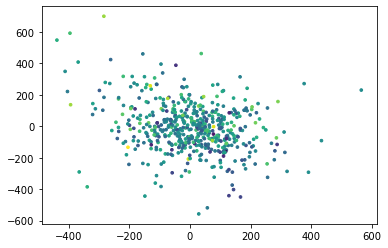

In [220]:
plt.scatter(U_df[0],U_df[1],c=U_df["ADP"],s=7)

In [221]:
U_df["r"] = np.linalg.norm(U_df[[0,1]],axis=1)

In [222]:
pearsonr(U_df.loc[c,""],U_df.loc[c,"ADP"])

(0.046876526011952226, 0.28367267184843004)

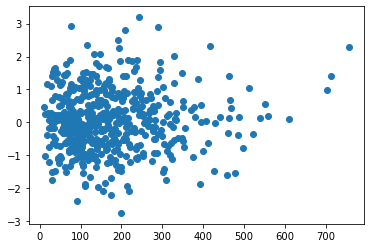

In [223]:
plt.scatter(U_df["r"],U_df["ADP"])

In [224]:
from sklearn.ensemble import RandomForestRegressor

In [225]:
rf = RandomForestRegressor()

In [226]:
X_ = U_df[["PLT","MPV","PDW","PCT","IPF","cohort","SEX","AGE"]]
Y_ = U_df[[0,1]]

In [227]:
rf.fit(X_,Y_)
Y_p = rf.predict(X_)

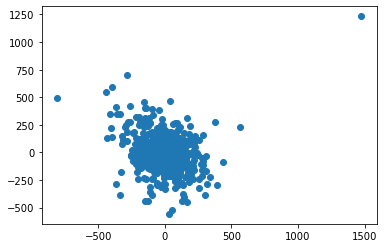

In [228]:
plt.scatter(U_df[0],U_df[1])

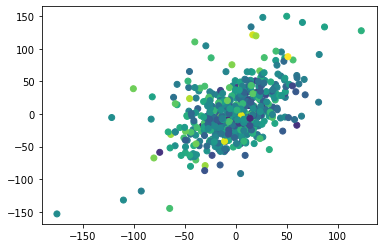

In [229]:
c = ~U_df.ADP.isnull()
plt.scatter(Y_p[c,0]-U_df.loc[c,0],Y_p[c,1]-U_df.loc[c,1],c=U_df.loc[c,"ADP"])

In [230]:
from scipy.stats import pearsonr

In [231]:
U_df["d_0"] = Y_p[c,0]-U_df.loc[c,0]
U_df["d_1"] = Y_p[c,1]-U_df.loc[c,1]

In [232]:
rf2 = RandomForestRegressor()
c = ~U_df.ADP.isnull()
rf2.fit(U_df.loc[c,["d_0","d_1"]],U_df.loc[c,"ADP"])

RandomForestRegressor()

In [235]:
pearsonr(U_df.loc[c,"d_1"],U_df.loc[c,"ADP"])

(0.0797365663926068, 0.06791852104331257)

In [233]:
pearsonr(U_df.loc[c,"d_0"],U_df.loc[c,"ADP"])

(-0.11407726643012332, 0.008892654616346132)

In [238]:
pearsonr(U_df.loc[c,"r"],U_df.loc[c,"ADP"])

(0.046876526011952226, 0.28367267184843004)

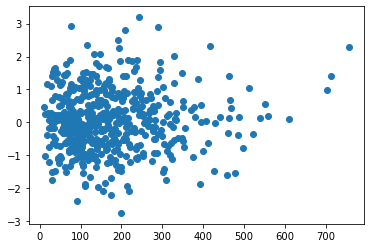

In [237]:
plt.scatter(U_df.loc[c,"r"],U_df.loc[c,"ADP"])

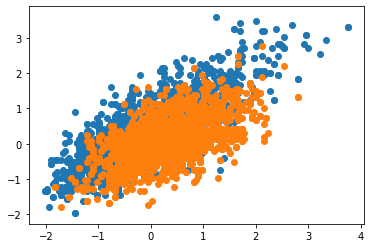

In [169]:
plt.scatter(Xs["INT_116_1095300"][:,0],Xs["INT_116_1095300"][:,1])
plt.scatter(Xs["C19759"][:,0],Xs["C19759"][:,1])